In [3]:
import bluefog.torch as bf
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch

%matplotlib inline

In [23]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [24]:
%%px
import torch
import bluefog.torch as bf
from bluefog.common import topology_util

bf.init()

print(f"Rank: {bf.rank()}, Size: {bf.size()}")

[stdout:0] Rank: 0, Size: 8
[stdout:1] Rank: 5, Size: 8
[stdout:2] Rank: 7, Size: 8
[stdout:3] Rank: 6, Size: 8
[stdout:4] Rank: 4, Size: 8
[stdout:5] Rank: 1, Size: 8
[stdout:6] Rank: 3, Size: 8
[stdout:7] Rank: 2, Size: 8


#  Average Consensus Over General Dynamic Topology

In previous example, dynamic one peer strategy over exponential 2 graph has several nice properties. Every iteration, the combination matrix $W$ is always doubly stochastic. This guarantees the unbiased result of running average consensus algorithm. However, this property no longer holds for general case. Let's use star graph to illustrate that.


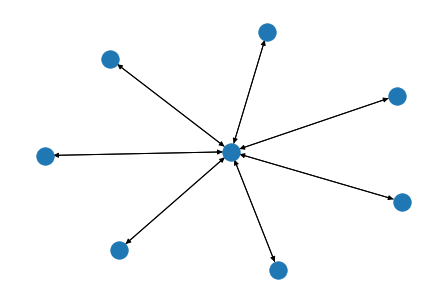

In [4]:
nx.draw_spring(bf.StarGraph(8))

In [7]:
generator = bf.GetDynamicOnePeerSendRecvRanks(bf.StarGraph(8), self_rank=0)
for _ in range(10):
    print(next(generator))

([1], [1, 2, 3, 4, 5, 6, 7])
([2], [1, 2, 3, 4, 5, 6, 7])
([3], [1, 2, 3, 4, 5, 6, 7])
([4], [1, 2, 3, 4, 5, 6, 7])
([5], [1, 2, 3, 4, 5, 6, 7])
([6], [1, 2, 3, 4, 5, 6, 7])
([7], [1, 2, 3, 4, 5, 6, 7])
([1], [1, 2, 3, 4, 5, 6, 7])
([2], [1, 2, 3, 4, 5, 6, 7])
([3], [1, 2, 3, 4, 5, 6, 7])


In [10]:
%%px
data_size = 1
seed = 1234
max_iters = 100
torch.random.manual_seed(seed * bf.rank())

x = torch.randn(data_size, dtype=torch.double)
x_bar = bf.allreduce(x, average=True)

In [11]:
%%px
bf.set_topology(topology_util.StarGraph(bf.size()))
dynamic_neighbor_allreduce_gen = topology_util.GetDynamicOnePeerSendRecvRanks(
    bf.load_topology(), bf.rank()
)
x_list = []
for ite in range(max_iters):
    send_neighbors, recv_neighbors = next(dynamic_neighbor_allreduce_gen)
    uniform_weight = 1 / (len(recv_neighbors) + 1)
    neighbor_weights = {r: uniform_weight for r in recv_neighbors}
    self_weight = uniform_weight

    x = bf.neighbor_allreduce(
        x,
        name="x",
        self_weight=self_weight,
        src_weights=neighbor_weights,
        dst_weights=send_neighbors,
        enable_topo_check=True,
    )
    x_list.append(x)

In [12]:
x_all_ranks = rc[:].pull("x_list", block=True)
x_bar = rc[0].pull("x_bar", block=True)

Text(0, 0.5, 'value')

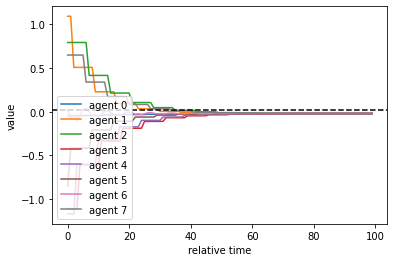

In [13]:
for i in rc.ids:
    plt.plot(x_all_ranks[i], label=f"agent {i}")
plt.axhline(x_bar, linestyle="--", color="k")
plt.legend()
plt.xlabel("relative time")
plt.ylabel("value")

Text(0, 0.5, 'value')

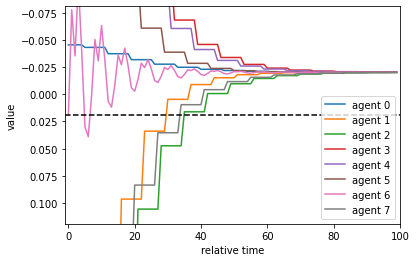

In [14]:
for i in rc.ids:
    plt.plot(x_all_ranks[i], label=f"agent {i}")
plt.axhline(x_bar, linestyle="--", color="k")
plt.legend()

plt.axis([-1, len(x_all_ranks[0]), x_bar + 0.1, x_bar - 0.1])
plt.xlabel("relative time")
plt.ylabel("value")

We can see that although all agents converge to one consensus value, it is different from the true mean as expected.

# Push-Sum Consensus Algorithm
The Push-Sum consensus algorithm is proposed to correct these biased problem. 
The algorithm is to introduce another weights $p$ and the final average concensus value is the original vector divided by the weights.
For each agent $i$, run it in parallel:
$$
    x_{i, k+1} = \sum_{j\in \mathcal{N}_i} w_{ij}^{(k)} x_{j,k}\\
    p_{i, k+1} = \sum_{j\in \mathcal{N}_i} w_{ij}^{(k)} p_{j,k}\\
    y_{i, k+1} = x_{i, k+1} / p_{i, k+1}
$$
where $p_{i, 0}$ is initialize as 1.
Here is one restriction here the combination matrix $[w_{ij}]$ has to be column stochastic matrix, i.e.
$$
    \sum_{j} w_{ij} = 1.
$$
instead of row stochastic matrix.
Under this property and more connective assumption, it can be shown that 
\begin{align}
    \mathbb{1}^T p_k &\;\equiv \mathbb{1}, \\
    \mathbb{1}^T x_{k} &\; = \mathbb{1}^T x_{k-1} = \cdots = \mathbb{1}^T x_{0},\\
    x_{k}/p_{k} &\;\to \frac{1}{N} \mathbb{1}^T x_{0} \mathbb{1}
\end{align}

However, there is one problem that if we normalize the recieve weights through the recieving rank list, we will generate row stochastic matrix instead of column one. 
In this case, we should use `dst_weights` argument instead of `src_weights`.


In [18]:
%%px
x = torch.randn(data_size, dtype=torch.double)
p = torch.ones(1)  # the correction weights
x_bar = bf.allreduce(x, average=True)

In [19]:
%%px
bf.set_topology(topology_util.MeshGrid2DGraph(bf.size()))
dynamic_neighbor_gen = topology_util.GetDynamicOnePeerSendRecvRanks(
    bf.load_topology(), bf.rank()
)
x_list = []
y_list = []
for ite in range(max_iters):
    dst_neighbors, src_neighbors = next(dynamic_neighbor_gen)
    src_weights = {r: 1 for r in src_neighbors}
    self_weight = 1 / (len(dst_neighbors) + 1)
    dst_weights = {r: self_weight for r in dst_neighbors}
    x = bf.neighbor_allreduce(
        x,
        name="x",
        self_weight=self_weight,
        src_weights=src_weights,
        dst_weights=dst_weights,
        enable_topo_check=True,
    )
    p = bf.neighbor_allreduce(
        p,
        name="p",
        self_weight=self_weight,
        src_weights=src_weights,
        dst_weights=dst_weights,
        enable_topo_check=True,
    )
    x_list.append(x)
    y_list.append(x / p)

Text(0, 0.5, 'value')

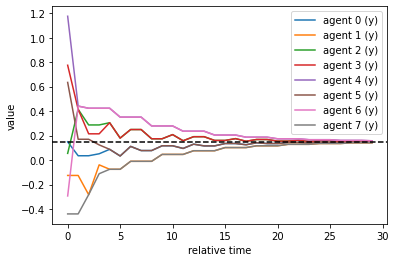

In [20]:
x_bar = rc[0].pull("x_bar", block=True)
x_all_ranks = rc[:].pull("x_list", block=True)
y_all_ranks = rc[:].pull("y_list", block=True)
for i in rc.ids:
    plt.plot(y_all_ranks[i], label=f"agent {i} (y)")
plt.axhline(x_bar, linestyle="--", color="k")
plt.legend()
plt.xlabel("relative time")
plt.ylabel("value")